In [1]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from PIL import Image

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

In [3]:
parasitized=os.listdir('cell_images/Parasitized')
uninfected=os.listdir('cell_images/Uninfected')

In [4]:
data=[]
labels=[]

for a in parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
  

In [5]:
for b in uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [6]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells_140' , cells)
np.save('Labels_140' , labels)

In [3]:
cells=np.load('Cells_140.npy')
labels=np.load('Labels_140.npy')

In [4]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [5]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [6]:
train_x.shape

(22046, 140, 140, 3)

In [7]:
train_x = train_x.astype('float32')
eval_x = eval_x.astype('float32')
test_x = test_x.astype('float32')

 # preprocess data
train_x = train_x / 255.0
eval_x = eval_x / 255.0
test_x= test_x /255.0

In [9]:
train_x.shape

(22046, 140, 140, 3)

In [10]:
img_rows=140
img_cols=140
num_classes=2
epochs = 10
batch_size = 128

In [11]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [12]:
test_y1=test_y
test_y1

array([0, 0, 0, ..., 1, 0, 0])

In [13]:
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [14]:
num_classes=len(np.unique(labels))
num_classes

2

In [15]:
inception=InceptionV3(include_top=False,weights='imagenet',input_shape=(140, 140, 3))
print(inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 140, 140, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
#source:https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
x = inception.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(102, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [19]:
# this is the model we will train
model = Model(inputs=inception.input, outputs=predictions)

In [20]:
# Freeze the layers 
for layer in inception.layers:
    layer.trainable = False
 
#Check the trainable status of the individual layers
for layer in inception.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x000002B441E7B780> False
<keras.layers.convolutional.Conv2D object at 0x000002B441E7B080> False
<keras.layers.normalization.BatchNormalization object at 0x000002B441C18160> False
<keras.layers.core.Activation object at 0x000002B441E812B0> False
<keras.layers.convolutional.Conv2D object at 0x000002B441C12FD0> False
<keras.layers.normalization.BatchNormalization object at 0x000002B441D4E390> False
<keras.layers.core.Activation object at 0x000002B441DF3C18> False
<keras.layers.convolutional.Conv2D object at 0x000002B441DEBDD8> False
<keras.layers.normalization.BatchNormalization object at 0x000002B441C4F898> False
<keras.layers.core.Activation object at 0x000002B44B08A400> False
<keras.layers.pooling.MaxPooling2D object at 0x000002B51C8523C8> False
<keras.layers.convolutional.Conv2D object at 0x000002B51C86FE10> False
<keras.layers.normalization.BatchNormalization object at 0x000002B51C8BE160> False
<keras.layers.core.Activation object at 0x000

In [21]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.


Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 54s 2ms/step - loss: 0.4436 - acc: 0.8127 - val_loss: 0.4458 - val_acc: 0.7921
Epoch 2/10
22046/22046 [==============================] - 36s 2ms/step - loss: 0.3128 - acc: 0.8836 - val_loss: 0.4157 - val_acc: 0.8284
Epoch 3/10
22046/22046 [==============================] - 36s 2ms/step - loss: 0.2771 - acc: 0.8979 - val_loss: 0.4190 - val_acc: 0.8284
Epoch 4/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.2605 - acc: 0.9037 - val_loss: 0.4611 - val_acc: 0.8193
Epoch 5/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.2440 - acc: 0.9102 - val_loss: 0.4011 - val_acc: 0.8411
Epoch 6/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.2410 - acc: 0.9085 - val_loss: 0.3894 - val_acc: 0.8476
Epoch 7/10
22046/22046 [==============================] - 38s 2ms/step - loss: 0.2298 - acc: 0.9148 - val_loss: 0.4102 - val_acc:

In [23]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(inception.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [24]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [25]:
from keras.optimizers import SGD

In [26]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='categorical_crossentropy',
             metrics=['accuracy'])

history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 53s 2ms/step - loss: 0.1779 - acc: 0.9414 - val_loss: 0.8464 - val_acc: 0.7692
Epoch 2/10
22046/22046 [==============================] - 44s 2ms/step - loss: 0.0931 - acc: 0.9677 - val_loss: 1.8369 - val_acc: 0.6840
Epoch 3/10
22046/22046 [==============================] - 44s 2ms/step - loss: 0.0562 - acc: 0.9794 - val_loss: 2.5697 - val_acc: 0.6081
Epoch 4/10
22046/22046 [==============================] - 46s 2ms/step - loss: 0.0429 - acc: 0.9844 - val_loss: 1.6906 - val_acc: 0.7877
Epoch 5/10
22046/22046 [==============================] - 46s 2ms/step - loss: 0.0282 - acc: 0.9898 - val_loss: 3.2109 - val_acc: 0.6012
Epoch 6/10
22046/22046 [==============================] - 46s 2ms/step - loss: 0.0282 - acc: 0.9908 - val_loss: 3.6879 - val_acc: 0.5991
Epoch 7/10
22046/22046 [==============================] - 46s 2ms/step - loss: 0.0218 - acc: 0.9923 - val_loss: 3.3213 - val_acc:

In [27]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

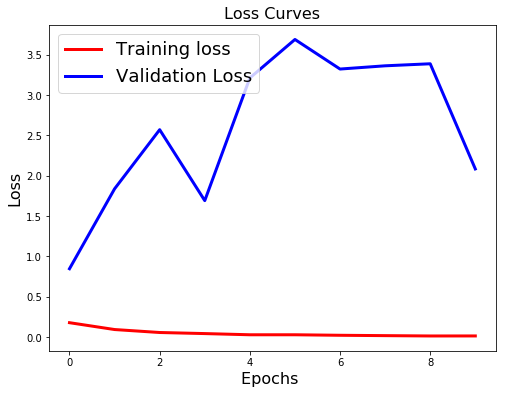

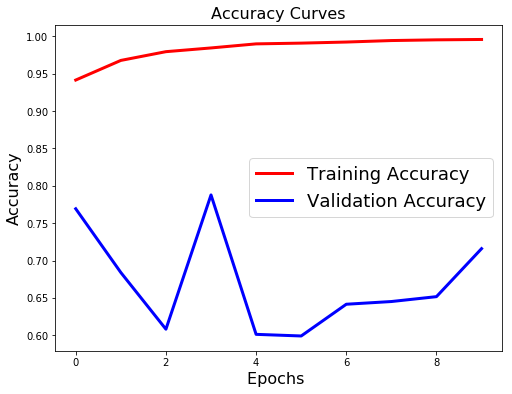

In [28]:
plot_loss_acc_curves(history)

In [52]:
classes=model.predict(test_x,batch_size=128)

In [53]:
y_classes = classes.argmax(axis=-1)
y_classes

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

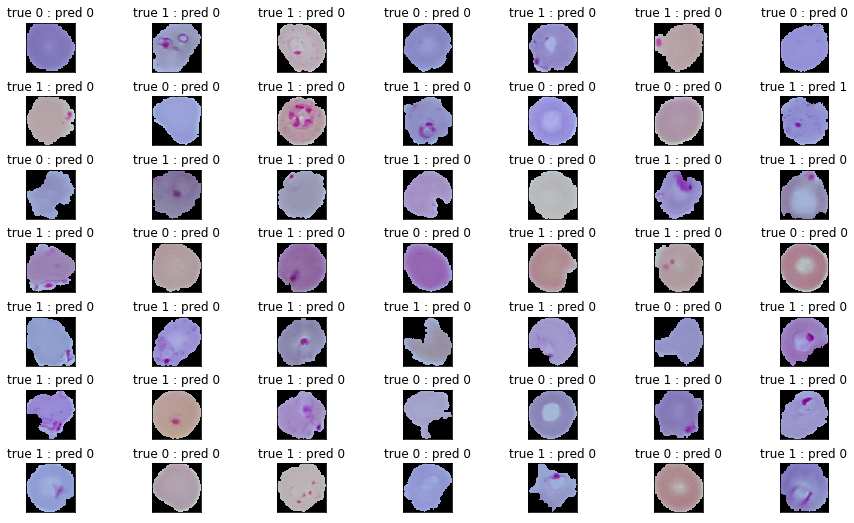

In [54]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , y_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()